In [84]:
import numpy as np
import pandas as pd
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
Bike=pd.read_csv("PowerAD.csv")
power=pd.read_csv("power.csv",header=None).values.astype('float32')
power=np.reshape(power,(365,96))
mean_class=pd.read_csv("mean_class.csv")
DForecast=340
ClassofForecast=1

In [85]:
def preprocess(data,window):
    matrix=data.as_matrix()
    array = []
    y=[]
    #len(data)資料筆數
    for index in range(len(matrix) - window):
        array.append(matrix[index : index + window])
        y.append(matrix[index +window])
    array=np.array(array)
    y=np.array(y)
    return array,y

In [88]:
def normalize(value):
    result=(value-mean)/std
    return result
def normalize_inverse(value):
    result=value*std+mean
    return result

In [86]:
train=Bike.iloc[((DForecast-1-14)*96):((DForecast-1)*96)]
test =Bike.iloc[((DForecast-1-1)*96):(DForecast*96)]
mean =np.mean(train)[0]
std  =np.std(train)[0]
#test.shape

In [89]:
all_data=normalize(Bike)

In [121]:
x_all_data,y_all_data=preprocess(all_data,96)
#x_all_data.shape

In [91]:
x_all_data=x_all_data.reshape(x_all_data.shape[0],1,x_all_data.shape[1])

In [92]:
train_normalize=normalize(train)
test_normalize=normalize(test)

In [93]:
x_train,y_train=preprocess(train_normalize,96)
x_train=x_train.reshape(x_train.shape[0],1,x_train.shape[1])
y_train=y_train.reshape(y_train.shape[0])

In [94]:
x_test,y_test=preprocess(test_normalize,96)
x_test=x_test.reshape(x_test.shape[0],1,x_test.shape[1])
y_test=y_test.reshape(y_test.shape[0])

In [96]:
def reset_graph(seed=50):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [97]:
reset_graph()
n_steps = 1
n_inputs = 96
n_neurons = 5
n_outputs = 1
n_layers = 1
keep_prob = 0.5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs],name='X')
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs],name='y')

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
lstm_drop = [tf.contrib.rnn.DropoutWrapper(cell, state_keep_prob=keep_prob)
              for cell in lstm_cells]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_drop)
outputs_LSTM, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
outputs = tf.layers.dense(outputs_LSTM, n_outputs)

In [98]:
learning_rate = 0.0001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [99]:
n_epochs = 500 #疊代次數n_epochs*(trainshape/batch_size)次
batch_size = 96 #一次丟batch_size個
data_size = x_train.shape[0]

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        all_range = np.array(range(data_size))
        np.random.shuffle(all_range)
        for iteration in range( data_size // batch_size):
            n_batch = all_range[iteration*batch_size:(iteration+1)*batch_size]
            x_batch = x_train[n_batch]
            y_batch = y_train[n_batch].reshape(-1, n_steps, n_outputs)
            sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
    
    all_pred = sess.run(outputs, feed_dict={X: x_test})
    values = sess.run(tf.trainable_variables())
    all_state = sess.run(states, feed_dict={X: x_all_data})

In [100]:
y_pred=all_pred[:,:,:].reshape(96,1)#

In [101]:
Y=normalize_inverse(y_pred)#

In [102]:
x = np.array(list(range(1,97)))
y = mean_class.values.astype('float32')[:,(ClassofForecast-1)]
N, xmin, xmax = 1000, x.min(), x.max()
xx = np.linspace(xmin, xmax, N)

NInterpolate, Interpolate = 10, [] #NInterpolate為內點個數，Interpolate為所需要的內點
for i in range(NInterpolate):
    Interpolate.append(xmin+(i+1)*(xmax-xmin)/(NInterpolate+1))
S, K=75, 3

t, c, k = interpolate.splrep(x, y, s=S, k=K, task=-1, t=np.asarray([24,40,50,60,76])) 
spline = interpolate.BSpline(t, c, k, extrapolate=False)

In [103]:
LSTMBSPredict=Y.reshape(96,)+spline(x)

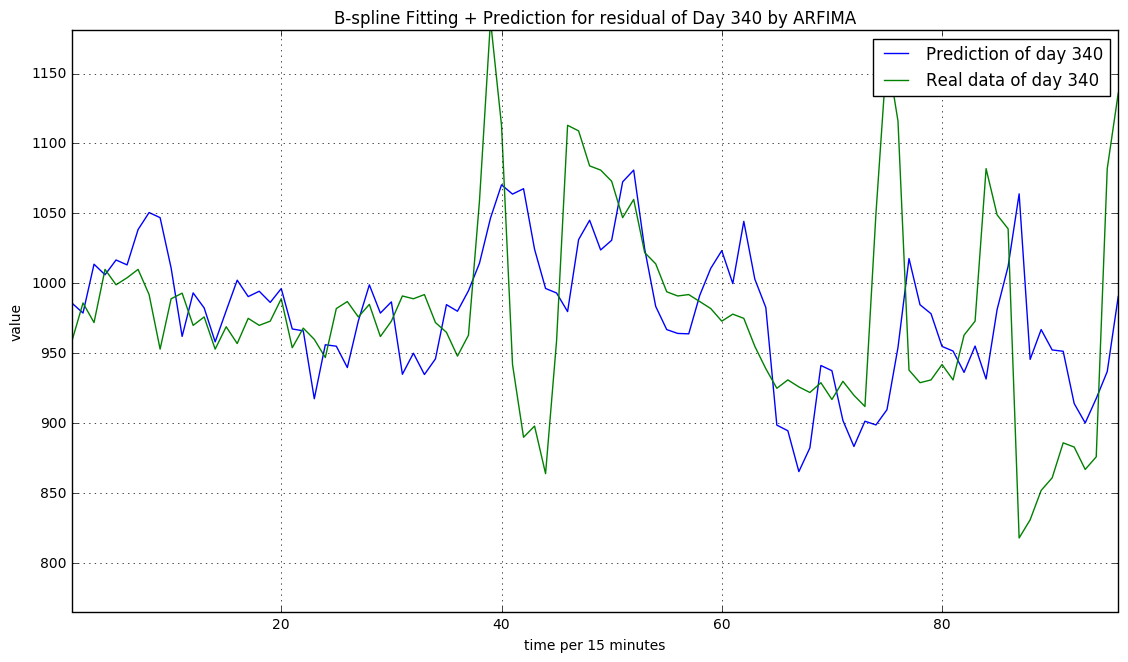

RMSE of Prediction : 72.263455509
雜訊訊號比 : 0.0738740624722


In [104]:
plt.figure(figsize=(13.5, 7.5))
plt.plot(x, LSTMBSPredict, 'b', label='Prediction of day '+str(DForecast))
plt.plot(x, power[DForecast-1], 'g', label='Real data of day '+str(DForecast))
plt.xlim(xmin, xmax); plt.ylim(np.min(LSTMBSPredict)-100, np.max(LSTMBSPredict)+100)
plt.legend()
plt.xlabel('time per 15 minutes'); plt.ylabel('value')
plt.title("B-spline Fitting + Prediction for residual of Day "+str(DForecast)+" by ARFIMA")
plt.grid()
#plt.savefig('PredictClass5.jpg')
plt.show()
NSR=np.sqrt(mean_squared_error(LSTMBSPredict,power[DForecast-1])) / np.mean(power[DForecast-1]) #雜訊訊號比
RMSEprediction=np.sqrt(mean_squared_error(LSTMBSPredict,power[DForecast-1]))
print("RMSE of Prediction",":",RMSEprediction)
print("雜訊訊號比",":",NSR)

#### 每一類抽樣去跑

In [126]:
import numpy as np
import pandas as pd
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import datetime
Data=pd.read_csv("PowerAD.csv")
power=pd.read_csv("power.csv",header=None).values.astype('float32')
power=np.reshape(power,(365,96))
mean_class=pd.read_csv("mean_class.csv")
ArfimaPredictclass1=pd.read_csv("ArfimaPredictclass1.csv")
ArfimaPredictclass2=pd.read_csv("ArfimaPredictclass2.csv")
ArfimaPredictclass3=pd.read_csv("ArfimaPredictclass3.csv")
ArfimaPredictclass4=pd.read_csv("ArfimaPredictclass4.csv")
ArfimaPredictclass5=pd.read_csv("ArfimaPredictclass5.csv")
def preprocess(data,window):
    matrix=data.as_matrix()
    array = []
    y=[]
    #len(data)資料筆數
    for index in range(len(matrix) - window):
        array.append(matrix[index : index + window])
        y.append(matrix[index +window])
    array=np.array(array)
    y=np.array(y)
    return array,y
def normalize(value):
    result=(value-mean)/std
    return result
def normalize_inverse(value):
    result=value*std+mean
    return result
def reset_graph(seed=50):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [127]:
DClass1=[int(x) for x in list(ArfimaPredictclass1.columns)]
DClass2=[int(x) for x in list(ArfimaPredictclass2.columns)]
DClass3=[int(x) for x in list(ArfimaPredictclass3.columns)]
DClass4=[int(x) for x in list(ArfimaPredictclass4.columns)]
DClass5=[int(x) for x in list(ArfimaPredictclass5.columns)]
DClass1to5=[DClass1,DClass2,DClass3,DClass4,DClass5]

In [130]:
print("開始時間:", datetime.datetime.now())
for Class in range(5):
    DClass=DClass1to5[Class]
    DClass=list(filter(lambda x: x>7, DClass))#
    ClassofForecast=Class+1
    RMSEpredictionClass, NSRClass=[],[]
    print("Class",ClassofForecast,"抽樣天數如下:")
    for day in range(len(DClass)):
        DForecast=DClass[day]
        ##############LSTM############################
        train=Data.iloc[((DForecast-1-7)*96):((DForecast-1)*96)]#Data.iloc[((DForecast-1-7)*96):((DForecast-1)*96)]
        test =Data.iloc[((DForecast-1-1)*96):(DForecast*96)]
        mean,std=np.mean(train)[0], np.std(train)[0]

        all_data=normalize(Data)
        x_all_data,y_all_data=preprocess(all_data,96)
        x_all_data=x_all_data.reshape(x_all_data.shape[0],1,x_all_data.shape[1])
        train_normalize,test_normalize=normalize(train), normalize(test)
        x_train,y_train=preprocess(train_normalize,96)
        x_train,y_train=x_train.reshape(x_train.shape[0],1,x_train.shape[1]), y_train.reshape(y_train.shape[0])
        x_test,y_test=preprocess(test_normalize,96)
        x_test,y_test=x_test.reshape(x_test.shape[0],1,x_test.shape[1]), y_test.reshape(y_test.shape[0])

        reset_graph()
        n_steps = 1
        n_inputs = 96
        n_neurons = 5
        n_outputs = 1
        n_layers = 1
        keep_prob = 0.5

        X = tf.placeholder(tf.float32, [None, n_steps, n_inputs],name='X')
        y = tf.placeholder(tf.float32, [None, n_steps, n_outputs],name='y')

        lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
                      for layer in range(n_layers)]
        lstm_drop = [tf.contrib.rnn.DropoutWrapper(cell, state_keep_prob=keep_prob)
                      for cell in lstm_cells]
        multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_drop)
        outputs_LSTM, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
        outputs = tf.layers.dense(outputs_LSTM, n_outputs)

        learning_rate = 0.0001

        loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

        n_epochs = 500 #疊代次數n_epochs*(trainshape/batch_size)次
        batch_size = 96 #一次丟batch_size個
        data_size = x_train.shape[0]

        with tf.Session() as sess:
            init.run()
            for epoch in range(n_epochs):
                all_range = np.array(range(data_size))
                np.random.shuffle(all_range)
                for iteration in range( data_size // batch_size):
                    n_batch = all_range[iteration*batch_size:(iteration+1)*batch_size]
                    x_batch = x_train[n_batch]
                    y_batch = y_train[n_batch].reshape(-1, n_steps, n_outputs)
                    sess.run(training_op, feed_dict={X: x_batch, y: y_batch})

            all_pred = sess.run(outputs, feed_dict={X: x_test})
            values = sess.run(tf.trainable_variables())
            all_state = sess.run(states, feed_dict={X: x_all_data})
        y_pred=all_pred[:,:,:].reshape(96,1)#
        Y=normalize_inverse(y_pred)#
        #############B-Spline#######################
        x = np.array(list(range(1,97)))
        y = mean_class.values.astype('float32')[:,(ClassofForecast-1)]
        N, xmin, xmax = 1000, x.min(), x.max()
        xx = np.linspace(xmin, xmax, N)

        NInterpolate, Interpolate = 10, [] #NInterpolate為內點個數，Interpolate為所需要的內點
        for i in range(NInterpolate):
            Interpolate.append(xmin+(i+1)*(xmax-xmin)/(NInterpolate+1))
        S, K=75, 3

        t, c, k = interpolate.splrep(x, y, s=S, k=K, task=-1, t=np.asarray([24,40,50,60,76])) 
        spline = interpolate.BSpline(t, c, k, extrapolate=False)
        #############LSTM+B-Spline#######################
        LSTMBSPredict=Y.reshape(96,)+spline(x)
    
        NSR=np.sqrt(mean_squared_error(LSTMBSPredict,power[DForecast-1])) / np.mean(power[DForecast-1]) #雜訊訊號比
        RMSEprediction=np.sqrt(mean_squared_error(LSTMBSPredict,power[DForecast-1])) #RMSE
        print("Day",str(DForecast))
        RMSEpredictionClass.append(RMSEprediction)
        NSRClass.append(NSR)
    print("Class",ClassofForecast)
    print("平均NSR(%)",np.mean(NSRClass)*100)
    print("平均RMSE",np.mean(RMSEpredictionClass))
print("結束時間:", datetime.datetime.now())

開始時間: 2018-03-29 03:39:34.886606
Class 1 抽樣天數如下:
Day 18
Day 47
Day 235
Day 249
Day 256
Day 340
Class 1
平均NSR(%) 4.52236134493
平均RMSE 44.8274215041
Class 2 抽樣天數如下:
Day 8
Day 23
Day 38
Day 42
Day 45
Day 69
Day 70
Day 71
Day 76
Day 84
Day 86
Day 92
Day 98
Day 104
Day 106
Day 107
Day 170
Day 232
Day 238
Day 245
Day 248
Day 251
Day 252
Day 255
Day 262
Day 265
Day 267
Day 268
Day 273
Day 274
Day 275
Day 279
Day 286
Day 287
Day 296
Day 309
Day 315
Day 318
Day 325
Day 356
Day 357
Class 2
平均NSR(%) 4.94258023276
平均RMSE 62.3577938232
Class 3 抽樣天數如下:
Day 13
Day 15
Day 29
Day 44
Day 48
Day 57
Day 83
Day 323
Day 329
Day 338
Day 342
Day 349
Class 3
平均NSR(%) 5.63505451732
平均RMSE 75.0197152579
Class 4 抽樣天數如下:
Day 26
Day 60
Day 68
Day 75
Day 103
Day 123
Day 137
Day 138
Day 145
Day 152
Day 158
Day 159
Day 173
Day 179
Day 180
Day 194
Day 207
Day 242
Day 264
Day 278
Day 284
Day 298
Day 312
Day 313
Day 326
Day 341
Day 348
Day 354
Day 360
Class 4
平均NSR(%) 4.02536601669
平均RMSE 36.4724488367
Class 5 抽樣天數如下:
Da

In [ ]:
#2 weeks

In [131]:
print("開始時間:", datetime.datetime.now())
for Class in range(5):
    DClass=DClass1to5[Class]
    DClass=list(filter(lambda x: x>14, DClass))#
    ClassofForecast=Class+1
    RMSEpredictionClass, NSRClass=[],[]
    print("Class",ClassofForecast,"抽樣天數如下:")
    for day in range(len(DClass)):
        DForecast=DClass[day]
        ##############LSTM############################
        train=Data.iloc[((DForecast-1-14)*96):((DForecast-1)*96)]#Data.iloc[((DForecast-1-7)*96):((DForecast-1)*96)]
        test =Data.iloc[((DForecast-1-1)*96):(DForecast*96)]
        mean,std=np.mean(train)[0], np.std(train)[0]

        all_data=normalize(Data)
        x_all_data,y_all_data=preprocess(all_data,96)
        x_all_data=x_all_data.reshape(x_all_data.shape[0],1,x_all_data.shape[1])
        train_normalize,test_normalize=normalize(train), normalize(test)
        x_train,y_train=preprocess(train_normalize,96)
        x_train,y_train=x_train.reshape(x_train.shape[0],1,x_train.shape[1]), y_train.reshape(y_train.shape[0])
        x_test,y_test=preprocess(test_normalize,96)
        x_test,y_test=x_test.reshape(x_test.shape[0],1,x_test.shape[1]), y_test.reshape(y_test.shape[0])

        reset_graph()
        n_steps = 1
        n_inputs = 96
        n_neurons = 5
        n_outputs = 1
        n_layers = 1
        keep_prob = 0.5

        X = tf.placeholder(tf.float32, [None, n_steps, n_inputs],name='X')
        y = tf.placeholder(tf.float32, [None, n_steps, n_outputs],name='y')

        lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
                      for layer in range(n_layers)]
        lstm_drop = [tf.contrib.rnn.DropoutWrapper(cell, state_keep_prob=keep_prob)
                      for cell in lstm_cells]
        multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_drop)
        outputs_LSTM, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
        outputs = tf.layers.dense(outputs_LSTM, n_outputs)

        learning_rate = 0.0001

        loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

        n_epochs = 500 #疊代次數n_epochs*(trainshape/batch_size)次
        batch_size = 96 #一次丟batch_size個
        data_size = x_train.shape[0]

        with tf.Session() as sess:
            init.run()
            for epoch in range(n_epochs):
                all_range = np.array(range(data_size))
                np.random.shuffle(all_range)
                for iteration in range( data_size // batch_size):
                    n_batch = all_range[iteration*batch_size:(iteration+1)*batch_size]
                    x_batch = x_train[n_batch]
                    y_batch = y_train[n_batch].reshape(-1, n_steps, n_outputs)
                    sess.run(training_op, feed_dict={X: x_batch, y: y_batch})

            all_pred = sess.run(outputs, feed_dict={X: x_test})
            values = sess.run(tf.trainable_variables())
            all_state = sess.run(states, feed_dict={X: x_all_data})
        y_pred=all_pred[:,:,:].reshape(96,1)#
        Y=normalize_inverse(y_pred)#
        #############B-Spline#######################
        x = np.array(list(range(1,97)))
        y = mean_class.values.astype('float32')[:,(ClassofForecast-1)]
        N, xmin, xmax = 1000, x.min(), x.max()
        xx = np.linspace(xmin, xmax, N)

        NInterpolate, Interpolate = 10, [] #NInterpolate為內點個數，Interpolate為所需要的內點
        for i in range(NInterpolate):
            Interpolate.append(xmin+(i+1)*(xmax-xmin)/(NInterpolate+1))
        S, K=75, 3

        t, c, k = interpolate.splrep(x, y, s=S, k=K, task=-1, t=np.asarray([24,40,50,60,76])) 
        spline = interpolate.BSpline(t, c, k, extrapolate=False)
        #############LSTM+B-Spline#######################
        LSTMBSPredict=Y.reshape(96,)+spline(x)
    
        NSR=np.sqrt(mean_squared_error(LSTMBSPredict,power[DForecast-1])) / np.mean(power[DForecast-1]) #雜訊訊號比
        RMSEprediction=np.sqrt(mean_squared_error(LSTMBSPredict,power[DForecast-1])) #RMSE
        print("Day",str(DForecast))
        RMSEpredictionClass.append(RMSEprediction)
        NSRClass.append(NSR)
    print("Class",ClassofForecast)
    print("平均NSR(%)",np.mean(NSRClass)*100)
    print("平均RMSE",np.mean(RMSEpredictionClass))
print("結束時間:", datetime.datetime.now())

開始時間: 2018-03-29 04:08:31.600883
Class 1 抽樣天數如下:
Day 18
Day 47
Day 235
Day 249
Day 256
Day 340
Class 1
平均NSR(%) 4.15783397922
平均RMSE 41.1868964802
Class 2 抽樣天數如下:
Day 23
Day 38
Day 42
Day 45
Day 69
Day 70
Day 71
Day 76
Day 84
Day 86
Day 92
Day 98
Day 104
Day 106
Day 107
Day 170
Day 232
Day 238
Day 245
Day 248
Day 251
Day 252
Day 255
Day 262
Day 265
Day 267
Day 268
Day 273
Day 274
Day 275
Day 279
Day 286
Day 287
Day 296
Day 309
Day 315
Day 318
Day 325
Day 356
Day 357
Class 2
平均NSR(%) 4.36862925243
平均RMSE 55.0908259298
Class 3 抽樣天數如下:
Day 15
Day 29
Day 44
Day 48
Day 57
Day 83
Day 323
Day 329
Day 338
Day 342
Day 349
Class 3
平均NSR(%) 4.8878883165
平均RMSE 65.1949167816
Class 4 抽樣天數如下:
Day 26
Day 60
Day 68
Day 75
Day 103
Day 123
Day 137
Day 138
Day 145
Day 152
Day 158
Day 159
Day 173
Day 179
Day 180
Day 194
Day 207
Day 242
Day 264
Day 278
Day 284
Day 298
Day 312
Day 313
Day 326
Day 341
Day 348
Day 354
Day 360
Class 4
平均NSR(%) 3.4179438162
平均RMSE 30.9579912334
Class 5 抽樣天數如下:
Day 94
Day 112
Da

In [ ]:
#all train

In [132]:
print("開始時間:", datetime.datetime.now())
for Class in range(5):
    DClass=DClass1to5[Class]
    #DClass=list(filter(lambda x: x>14, DClass))#
    ClassofForecast=Class+1
    RMSEpredictionClass, NSRClass=[],[]
    print("Class",ClassofForecast,"抽樣天數如下:")
    for day in range(len(DClass)):
        DForecast=DClass[day]
        ##############LSTM############################
        train=Data.iloc[:((DForecast-1)*96)]#Data.iloc[((DForecast-1-7)*96):((DForecast-1)*96)]
        test =Data.iloc[((DForecast-1-1)*96):(DForecast*96)]
        mean,std=np.mean(train)[0], np.std(train)[0]

        all_data=normalize(Data)
        x_all_data,y_all_data=preprocess(all_data,96)
        x_all_data=x_all_data.reshape(x_all_data.shape[0],1,x_all_data.shape[1])
        train_normalize,test_normalize=normalize(train), normalize(test)
        x_train,y_train=preprocess(train_normalize,96)
        x_train,y_train=x_train.reshape(x_train.shape[0],1,x_train.shape[1]), y_train.reshape(y_train.shape[0])
        x_test,y_test=preprocess(test_normalize,96)
        x_test,y_test=x_test.reshape(x_test.shape[0],1,x_test.shape[1]), y_test.reshape(y_test.shape[0])

        reset_graph()
        n_steps = 1
        n_inputs = 96
        n_neurons = 5
        n_outputs = 1
        n_layers = 1
        keep_prob = 0.5

        X = tf.placeholder(tf.float32, [None, n_steps, n_inputs],name='X')
        y = tf.placeholder(tf.float32, [None, n_steps, n_outputs],name='y')

        lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
                      for layer in range(n_layers)]
        lstm_drop = [tf.contrib.rnn.DropoutWrapper(cell, state_keep_prob=keep_prob)
                      for cell in lstm_cells]
        multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_drop)
        outputs_LSTM, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
        outputs = tf.layers.dense(outputs_LSTM, n_outputs)

        learning_rate = 0.0001

        loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

        n_epochs = 500 #疊代次數n_epochs*(trainshape/batch_size)次
        batch_size = 96 #一次丟batch_size個
        data_size = x_train.shape[0]

        with tf.Session() as sess:
            init.run()
            for epoch in range(n_epochs):
                all_range = np.array(range(data_size))
                np.random.shuffle(all_range)
                for iteration in range( data_size // batch_size):
                    n_batch = all_range[iteration*batch_size:(iteration+1)*batch_size]
                    x_batch = x_train[n_batch]
                    y_batch = y_train[n_batch].reshape(-1, n_steps, n_outputs)
                    sess.run(training_op, feed_dict={X: x_batch, y: y_batch})

            all_pred = sess.run(outputs, feed_dict={X: x_test})
            values = sess.run(tf.trainable_variables())
            all_state = sess.run(states, feed_dict={X: x_all_data})
        y_pred=all_pred[:,:,:].reshape(96,1)#
        Y=normalize_inverse(y_pred)#
        #############B-Spline#######################
        x = np.array(list(range(1,97)))
        y = mean_class.values.astype('float32')[:,(ClassofForecast-1)]
        N, xmin, xmax = 1000, x.min(), x.max()
        xx = np.linspace(xmin, xmax, N)

        NInterpolate, Interpolate = 10, [] #NInterpolate為內點個數，Interpolate為所需要的內點
        for i in range(NInterpolate):
            Interpolate.append(xmin+(i+1)*(xmax-xmin)/(NInterpolate+1))
        S, K=75, 3

        t, c, k = interpolate.splrep(x, y, s=S, k=K, task=-1, t=np.asarray([24,40,50,60,76])) 
        spline = interpolate.BSpline(t, c, k, extrapolate=False)
        #############LSTM+B-Spline#######################
        LSTMBSPredict=Y.reshape(96,)+spline(x)
    
        NSR=np.sqrt(mean_squared_error(LSTMBSPredict,power[DForecast-1])) / np.mean(power[DForecast-1]) #雜訊訊號比
        RMSEprediction=np.sqrt(mean_squared_error(LSTMBSPredict,power[DForecast-1])) #RMSE
        print("Day",str(DForecast))
        RMSEpredictionClass.append(RMSEprediction)
        NSRClass.append(NSR)
    print("Class",ClassofForecast)
    print("平均NSR(%)",np.mean(NSRClass)*100)
    print("平均RMSE",np.mean(RMSEpredictionClass))
print("結束時間:", datetime.datetime.now())

開始時間: 2018-03-29 05:01:35.749493
Class 1 抽樣天數如下:
Day 18
Day 47
Day 235
Day 249
Day 256
Day 340
Class 1
平均NSR(%) 3.3327802818
平均RMSE 33.0342601765
Class 2 抽樣天數如下:
Day 8
Day 23
Day 38
Day 42
Day 45
Day 69
Day 70
Day 71
Day 76
Day 84
Day 86
Day 92
Day 98
Day 104
Day 106
Day 107
Day 170
Day 232
Day 238
Day 245
Day 248
Day 251
Day 252
Day 255
Day 262
Day 265
Day 267
Day 268
Day 273
Day 274
Day 275
Day 279
Day 286
Day 287
Day 296
Day 309
Day 315
Day 318
Day 325
Day 356
Day 357
Class 2
平均NSR(%) 3.72075787348
平均RMSE 46.9785872597
Class 3 抽樣天數如下:
Day 13
Day 15
Day 29
Day 44
Day 48
Day 57
Day 83
Day 323
Day 329
Day 338
Day 342
Day 349
Class 3
平均NSR(%) 4.29850863334
平均RMSE 57.2700000812
Class 4 抽樣天數如下:
Day 26
Day 60
Day 68
Day 75
Day 103
Day 123
Day 137
Day 138
Day 145
Day 152
Day 158
Day 159
Day 173
Day 179
Day 180
Day 194
Day 207
Day 242
Day 264
Day 278
Day 284
Day 298
Day 312
Day 313
Day 326
Day 341
Day 348
Day 354
Day 360
Class 4
平均NSR(%) 2.47199938798
平均RMSE 22.3774385736
Class 5 抽樣天數如下:
Day

#### 只用來預測某一天

In [120]:
import numpy as np
import pandas as pd
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

Data=pd.read_csv("PowerAD.csv")
power=pd.read_csv("power.csv",header=None).values.astype('float32')
power=np.reshape(power,(365,96))
mean_class=pd.read_csv("mean_class.csv")
DForecast=17
ClassofForecast=3
########################
def preprocess(data,window):
    matrix=data.as_matrix()
    array = []
    y=[]
    #len(data)資料筆數
    for index in range(len(matrix) - window):
        array.append(matrix[index : index + window])
        y.append(matrix[index +window])
    array=np.array(array)
    y=np.array(y)
    return array,y
def normalize(value):
    result=(value-mean)/std
    return result
def normalize_inverse(value):
    result=value*std+mean
    return result
def reset_graph(seed=50):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
##############LSTM############################
train=Data.iloc[:((DForecast-1)*96)]#Data.iloc[((DForecast-1-7)*96):((DForecast-1)*96)]
test =Data.iloc[((DForecast-1-1)*96):(DForecast*96)]
mean,std=np.mean(train)[0], np.std(train)[0]

all_data=normalize(Data)
x_all_data,y_all_data=preprocess(all_data,96)
x_all_data=x_all_data.reshape(x_all_data.shape[0],1,x_all_data.shape[1])
train_normalize,test_normalize=normalize(train), normalize(test)
x_train,y_train=preprocess(train_normalize,96)
x_train,y_train=x_train.reshape(x_train.shape[0],1,x_train.shape[1]), y_train.reshape(y_train.shape[0])
x_test,y_test=preprocess(test_normalize,96)
x_test,y_test=x_test.reshape(x_test.shape[0],1,x_test.shape[1]), y_test.reshape(y_test.shape[0])

reset_graph()
n_steps = 1
n_inputs = 96
n_neurons = 5
n_outputs = 1
n_layers = 1
keep_prob = 0.5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs],name='X')
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs],name='y')

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
lstm_drop = [tf.contrib.rnn.DropoutWrapper(cell, state_keep_prob=keep_prob)
              for cell in lstm_cells]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_drop)
outputs_LSTM, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
outputs = tf.layers.dense(outputs_LSTM, n_outputs)

learning_rate = 0.0001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

n_epochs = 500 #疊代次數n_epochs*(trainshape/batch_size)次
batch_size = 96 #一次丟batch_size個
data_size = x_train.shape[0]

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        all_range = np.array(range(data_size))
        np.random.shuffle(all_range)
        for iteration in range( data_size // batch_size):
            n_batch = all_range[iteration*batch_size:(iteration+1)*batch_size]
            x_batch = x_train[n_batch]
            y_batch = y_train[n_batch].reshape(-1, n_steps, n_outputs)
            sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
    
    all_pred = sess.run(outputs, feed_dict={X: x_test})
    values = sess.run(tf.trainable_variables())
    all_state = sess.run(states, feed_dict={X: x_all_data})
y_pred=all_pred[:,:,:].reshape(96,1)#
Y=normalize_inverse(y_pred)#
#############B-Spline#######################
x = np.array(list(range(1,97)))
y = mean_class.values.astype('float32')[:,(ClassofForecast-1)]
N, xmin, xmax = 1000, x.min(), x.max()
xx = np.linspace(xmin, xmax, N)

NInterpolate, Interpolate = 10, [] #NInterpolate為內點個數，Interpolate為所需要的內點
for i in range(NInterpolate):
    Interpolate.append(xmin+(i+1)*(xmax-xmin)/(NInterpolate+1))
S, K=75, 3

t, c, k = interpolate.splrep(x, y, s=S, k=K, task=-1, t=np.asarray([24,40,50,60,76])) 
spline = interpolate.BSpline(t, c, k, extrapolate=False)
#############LSTM+B-Spline#######################
LSTMBSPredict=Y.reshape(96,)+spline(x)

#############計算NSR與RMSE#######################
NSR=np.sqrt(mean_squared_error(LSTMBSPredict,power[DForecast-1])) / np.mean(power[DForecast-1]) #雜訊訊號比
RMSEprediction=np.sqrt(mean_squared_error(LSTMBSPredict,power[DForecast-1]))
print("Day",str(DForecast))
print("RMSE:",RMSEprediction)
print("NSR(%):",NSR*100)

Day 17
RMSE: 51.4092950531
NSR(%): 3.82723209031
